# Rai Live System Analysis

In this notebook, we read in the data that was generated and saved as a csv from the [TheGraphDataSetCreation](TheGraphDataSetCreation.ipynb) notebook and examine the following three areas:


## Rough internal notes:
* Correlation of RAI to Eth price moves - EthRai(marketPriceEth), RaiUSD(marketPriceUsd),EthRaiTWAP, EthUSD price moves. Pull volumne data as well if possible
    * $P$ = Vector of Prices
    * $P^+$ = $P$  + $\Delta P$
    * $\Delta P$ = matrix * $P$
    * $M$ = (Identity + matrix)*$P$
    * $P^+$ = $M$*$P$
    * Model of the vector autocorrelation - https://en.wikipedia.org/wiki/Vector_autoregression
    * Document how and why
    * Inference about how these things move
    * Could be a rich, multi-causal relationship
    * Should compare Rai results to Eth
    * System level price dynamics
    * Need to scale data to the same order prior to regressor
    * Extend auto correlation analysis to include other signals, like the fraction of rai debt ceiling available and fraction of rai available in the uniswap instance.
    * Goal is to make some statements about how Rai is actually being dictated by Ethereum price moves.
* Resource allocation efficiency wrt airdrop policy analysis - Dataset creation first then policy analysis
    * Reward Rules - https://gist.github.com/stefanionescu/e66204be990f4bc113a022341cb39186 
    * Are people acting differently based off of the reward policies? Do individual agents strategies make sense given their capital available. How well explained is the behavior by these rewards. Can we measure the behavior changes with the reward changes?
    * Need event data by address. Users can be LPs or minters, users as ethereum addresses. In uniswap and on the rai contract. 
    * Primary key user - primary key event id. 
    * Need a new query. 
    * Getting the agent activity
    * Build user event sequence dataset.
    * Make off of one user first. - Z ethereum address - 0xDF290293C4A4d6eBe38Fd7085d7721041f927E0a
    * Have Z confirm
    * Event sequence of: transaction sequence: rai/eth swaps, add liquidity to the ETH/RAI uni pair, open safe, lock eth, withdraw eth, draw RAI, repay RAI
    * Global state at the time of the event (uniswap and rai systems). Local state is Z's Safe state. 
    
#### Will be built off of agent, simplified prices system data, full system datasets created above
* Effective rate of return for RAI minters given error conditions 
* Slippage Rates relative to Uniswap
* Effective Rate paid for debt

   



In [13]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.api import VAR


## Import data and add additional attributes

In [14]:
graphData = pd.read_csv('saved_results/RaiLiveGraphData.csv')
del graphData['Unnamed: 0']

In [15]:
graphData.head()

,blockNumber,erc20CoinTotalSupply,globalDebt,marketPriceEth,marketPriceUsd,redemptionPrice,redemptionRate,timestamp,redemptionPriceActual,redemptionRateActual
0,11857308,1988.440433,1988.577499,0.002589,4.670500,"{'block': '11849022', 'id': '0xe313271188492c4...",{'hourlyRate': '1'},1613338681,3.14,1.0
1,11860793,2788.440433,2788.617717,0.002481,4.377049,"{'block': '11860755', 'id': '0x40066774f6fb7d3...",{'hourlyRate': '1'},1613384616,3.14,1.0
2,11861040,2788.440433,2788.657935,0.002481,4.406833,"{'block': '11861008', 'id': '0x0d551e2a2d55fa8...",{'hourlyRate': '1'},1613387890,3.14,1.0
3,11861337,2788.440433,2788.657935,0.002481,4.419266,"{'block': '11861237', 'id': '0x5c67dbb323db039...",{'hourlyRate': '1'},1613392101,3.14,1.0
4,11861474,3048.440433,3048.645955,0.001769,3.194330,"{'block': '11861237', 'id': '0x5c67dbb323db039...",{'hourlyRate': '1'},1613394096,3.14,1.0


In [16]:
graphData.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,marketPriceEth,marketPriceUsd,timestamp,redemptionPriceActual,redemptionRateActual
count,8.340000e+02,8.340000e+02,8.340000e+02,834.000000,834.000000,8.340000e+02,834.000000,8.340000e+02
mean,1.197470e+07,3.305505e+07,3.350672e+07,0.001885,3.223918,1.614900e+09,3.066364,1.000000e+00
std,6.609387e+04,1.428475e+07,1.441385e+07,0.000302,0.447405,8.793311e+05,0.049342,1.633703e-08
min,1.185731e+07,1.988440e+03,1.988577e+03,0.001600,2.850455,1.613339e+09,3.013686,9.999999e-01
25%,1.191771e+07,2.714650e+07,2.737521e+07,0.001668,3.014544,1.614141e+09,3.017765,1.000000e+00
50%,1.197444e+07,3.449464e+07,3.546279e+07,0.001784,3.151019,1.614896e+09,3.049511,1.000000e+00
75%,1.203184e+07,4.553056e+07,4.571930e+07,0.002057,3.272902,1.615660e+09,3.119491,1.000000e+00
max,1.209052e+07,4.899876e+07,4.918825e+07,0.004474,8.055382,1.616441e+09,3.140000,1.000000e+00


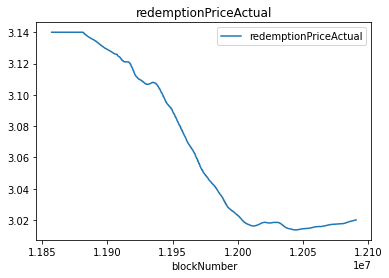

In [17]:
graphData.plot(x='blockNumber',y='redemptionPriceActual',kind='line',title='redemptionPriceActual')

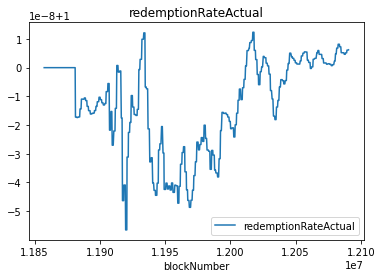

In [18]:
graphData.plot(x='blockNumber',y='redemptionRateActual',kind='line',title='redemptionRateActual')

In [19]:
graphData['error'] = graphData['redemptionPriceActual'] - graphData['marketPriceUsd']
graphData['error_integral'] = graphData['error'].cumsum()

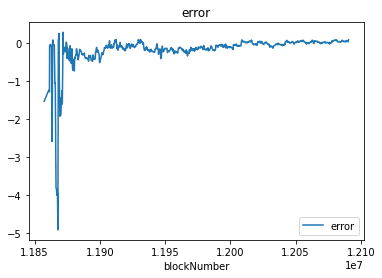

In [20]:
graphData.plot(x='blockNumber',y='error',kind='line',title='error')

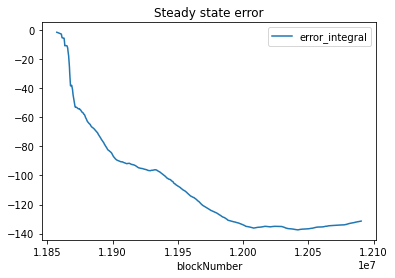

In [21]:
graphData.plot(x='blockNumber',y='error_integral',kind='line',title='Steady state error')

## Correlation of RAI to Eth price moves 

We are performing a vector autogression in order to determine if a casual or multi-casual relationship exists between Eth and Rai price moves. This will help use understand system level price dynamics of the Rai system.  

### Vector Autoregression 

Vector autoregression (VAR) is a type of statistical model used to capture the relationship between multiple time series signals as they change over time. VAR models are extensions of univaraite autoregression models allowing for multiivate rimme series.

Autogregressive models use lagged past values of the variable and have an order based on how many times the variable has been lagged. Lagged values help to determine if seasonality or reoccuring patterns exist in the data. 

For our VAR model, we will have a vector of prices, $P$ of the EthRai, EthRai(marketPriceEth),RaiUSD(marketPriceUsd), and EthUSD price moves

  
# Deviration: 
* $P^+$ = $P$  + $\Delta P$
* $\Delta P$ = matrix * $P$
* $M$ = (Identity + matrix)*$P$
* $P^+$ = $M$*$P$




# TODO
    * Need to scale data to the same order prior to regressor
    * Make stationary
    * Extend auto correlation analysis to include other signals, like the fraction of rai debt ceiling available and fraction of rai available in the uniswap instance.
    * Goal is to make some statements about how Rai is actually being dictated by Ethereum price moves.
    * Re



In [22]:
P = graphData[['marketPriceEth','marketPriceUsd']]

#In [12]: data = np.log(mdata).diff().dropna()

In [23]:
P

,marketPriceEth,marketPriceUsd
0,0.002589,4.670500
1,0.002481,4.377049
2,0.002481,4.406833
3,0.002481,4.419266
4,0.001769,3.194330
...,...,...
829,0.001662,2.961266
830,0.001663,2.957408
831,0.001676,2.968899
832,0.001674,2.983476


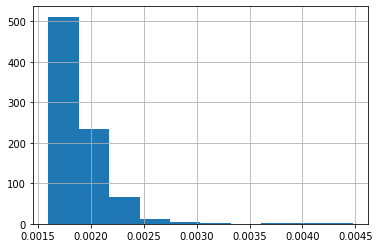

In [24]:
P.marketPriceEth.hist()

In [45]:
#P['marketPriceEthLogged'] = np.log(P.marketPriceEth.values)

<ipython-input-45-b6ffa0769fc9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P['marketPriceEthLogged'] = np.log(P.marketPriceEth.values)


In [54]:
# difference the data to make it stationary
P['marketPriceEthDiff'] = P['marketPriceEth'].diff()

<ipython-input-54-3c0d25c4185b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P['marketPriceEthDiff'] = P['marketPriceEth'].diff()


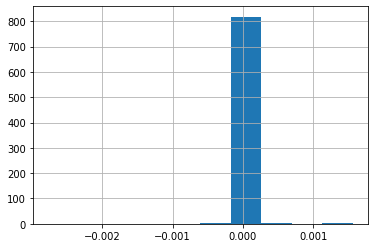

In [56]:
P['marketPriceEthDiff'].hist()

In [57]:
# difference the data to make it stationary
P['marketPriceUsdDiff'] = P['marketPriceUsd'].diff()

<ipython-input-57-8654cc557448>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P['marketPriceUsdDiff'] = P['marketPriceUsd'].diff()


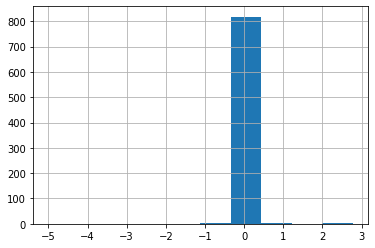

In [59]:
P.marketPriceUsdDiff.hist()

In [61]:
P[['marketPriceEthDiff','marketPriceUsdDiff']].describe()

,marketPriceEthDiff,marketPriceUsdDiff
count,8.330000e+02,833.000000
mean,-1.092811e-06,-0.002092
std,1.444976e-04,0.260884
min,-2.771131e-03,-5.002198
25%,-5.151244e-06,-0.015847
50%,-1.080731e-07,-0.000035
75%,2.776890e-06,0.014697
max,1.563076e-03,2.771804


Standardize the data (rescale values to mean of a 0 and a standard deviation of 1). Make sure the data is normal first, potentially perform a log transform.Standardization will move these different scales/order of magnitude to the same. 

In [62]:
from sklearn.preprocessing import StandardScaler
from math import sqrt

# train the standardization
scaler = StandardScaler()
# prepare data for standardization
values = P['marketPriceUsd'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized_marketPriceUsd = scaler.transform(values)
for i in range(5):
    print(normalized_marketPriceUsd[i])
# inverse transform and print the first 5 rows
#inversed = scaler.inverse_transform(normalized)

Mean: 3.223918, StandardDeviation: 0.447136
[3.23521482]
[2.57892547]
[2.64553531]
[2.67334044]
[-0.06617252]


<ipython-input-70-d2dbb3a1d146>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  P['normalized_marketPriceUsd'] = normalized_marketPriceUsd


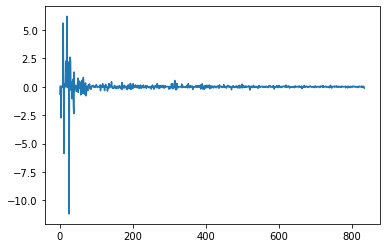

In [70]:
P['normalized_marketPriceUsd'] = normalized_marketPriceUsd
P['normalized_marketPriceUsd'].diff().plot()

# TODO: Convert to log or to the same scale

In [26]:
# instansiate the var model object from statsmodels
model = VAR(P)

In [27]:
# calculate the best autocorrelation value
#results = model.fit(2()
results = model.fit(maxlags=10, ic='aic')

In [28]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 22, Mar, 2021
Time:                     16:13:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -24.1826
Nobs:                     824.000    HQIC:                  -24.3307
Log likelihood:           7765.82    FPE:                2.47334e-11
AIC:                     -24.4229    Det(Omega_mle):     2.35193e-11
--------------------------------------------------------------------
Results for equation marketPriceEth
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.000135         0.000042            3.255           0.001
L1.marketPriceEth          1.276529         0.210594            6.062           0.000
L1.marketPriceUsd         -0.00

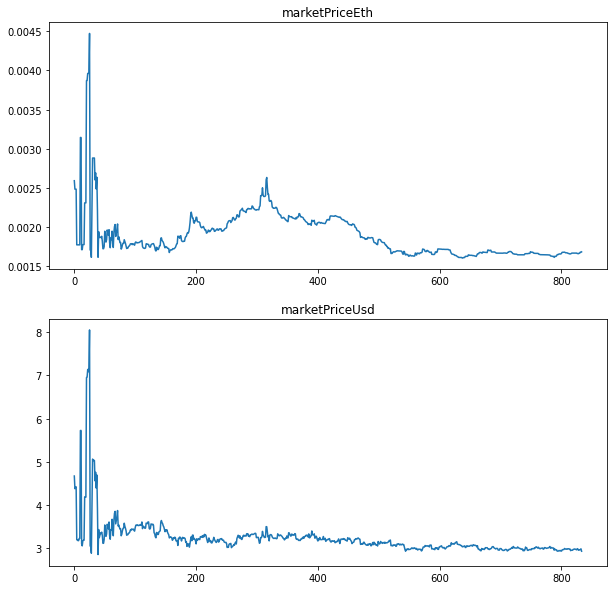

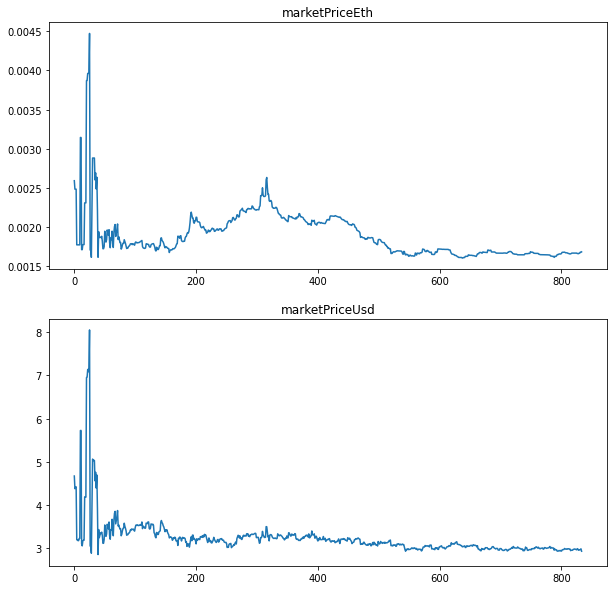

In [29]:
results.plot()

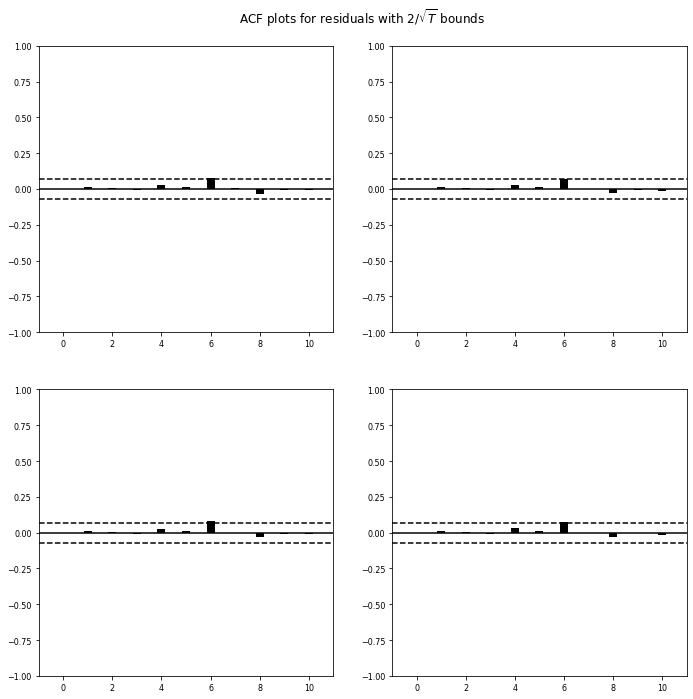

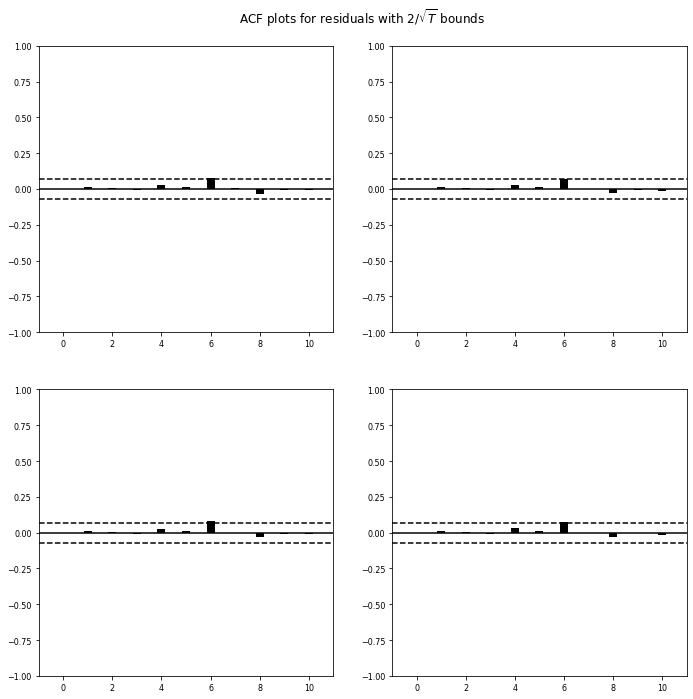

In [30]:
# plot the autocorrelation function
results.plot_acorr()

In [31]:
# Forecast
lag_order = results.k_ar

results.forecast(results.values[-lag_order:], 5)

AttributeError: 'VARResults' object has no attribute 'values'

## Impulse Response Analysis

Impulse response is used in econometrics to study how the estimated responses of a variable to a unit impulse.


In [ ]:
irf = results.irf(10)
irf.plot(impulse='marketPriceEth',orth=False)

Standard errors are plotted by default at the 95% significance level.

Cumulative effect:

In [ ]:
irf.plot_cum_effects(orth=False,impulse='marketPriceEth')

### Granger causality

"One is often interested in whether a variable or group of variables is “causal” for another variable, for some definition of “causal”. In the context of VAR models, one can say that a set of variables are Granger-causal within one of the VAR equations. We will not detail the mathematics or definition of Granger causality, but leave it to the reader. The VARResults object has the test_causality method for performing either a Wald (𝜒2) test or an F-test."

In [ ]:
results.test_causality('realgdp', ['realinv', 'realcons'], kind='f')

## Conclusion

